In [147]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import copy
%matplotlib inline

In [4]:
class CNN:
    
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learningrate):
        self.inodes = input_nodes
        self.hnodes = hidden_nodes
        self.onodes = output_nodes
        self.lr = learningrate
        
        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))
        
        self.lr = learningrate
        self.activation_function = lambda x: scipy.special.expit(x)
        
    def train(self, inputs_list, target_list):
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(target_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.who.T, output_errors)
        
        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0-final_outputs)), np.transpose(hidden_outputs))
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0-hidden_outputs)), np.transpose(inputs))
        
        pass
        
    def query(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs

In [5]:
input_nodes = 784
hidden_nodes = 200
output_nodes = 10
learning_rate = 0.2
cnn = CNN(input_nodes, hidden_nodes, output_nodes, learning_rate)

#Training Data
data_file = open("mnist_train.csv", 'r')
data_training_list = data_file.readlines()
data_file.close()

In [6]:
epochs = 2
for e in range(epochs):
    for record in data_training_list:
        all_values = record.split(',')
        inputs = (np.asfarray(all_values[1:])/255.0*0.99)+.01
        targets = np.zeros(output_nodes) + 0.01
        targets[int(all_values[0])] = 0.99
        cnn.train(inputs,targets)
        pass
    pass

In [62]:
test_data_file = open("mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [61]:
test_data = test_data_list[5]
test_data = test_data.split(',')
cnn.query((np.asfarray(test_data[1:])/255.0*0.99) + 0.01)

array([[0.00789725],
       [0.99778327],
       [0.00240952],
       [0.00802721],
       [0.05791565],
       [0.0217214 ],
       [0.00829976],
       [0.01122592],
       [0.00408788],
       [0.0044017 ]])

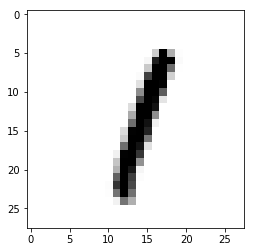

In [9]:
image_array = np.asfarray(test_data[1:]).reshape((28,28))
plt.imshow(image_array, cmap='Greys', interpolation='None')

In [10]:
scorecard = []

for record in test_data_list:
    all_values = record.split(',')
    correct_label = int(all_values[0])
    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    outputs = cnn.query(inputs)
    label = np.argmax(outputs)
    if (label == correct_label):
        scorecard.append(1)
    else:
        scorecard.append(0)
        pass    
    pass

In [11]:
scorecard_array = np.asarray(scorecard)
print ("performance = ", scorecard_array.sum() / scorecard_array.size)

performance =  0.961


In [166]:
#Begin Zero Pixel Attack using Differential Evolution Algorithm

def fobj(mnist, mnist_value):
    neural_eval = cnn.query((np.asfarray(mnist)/255.0*0.99) +0.01)
    return neural_eval[int(mnist_value)][0]

def fobj_whole_array(mnist, mnist_value):
    return cnn.query((np.asfarray(mnist)/255.0*0.99) +0.01)

#A (poor) implementation of the Differential Evolution Algorithm
def diff_evo(mnist, mnist_value, mut=0.8, crossover=0.5, n=784, popsize=20, iterations=100):
    #This tuple contains (DATA, CONFIDENCE INTERVALS, INDEXOFPIXEL, GRAYSCALEVALUE)
    current_min = (mnist, fobj(mnist, mnist_value), 0,254)
    agents = (np.random.rand(popsize)*n).astype(int)
    for j in range(iterations):
        for i in range(len(agents)):
            selection = np.random.choice(agents, 3, replace=False)
            while agents[i] in selection:
                selection = np.random.choice(agents,3,replace=False)
            random_index = np.random.choice(n,1)[0]
            uniform_loc = np.random.rand(1)[0]
            if uniform_loc < crossover or uniform_loc == random_index:
                y_i = selection[0] + mut * (selection[1]-selection[2])
            else:
                y_i = agents[i]
            if y_i > 783:
                y_i = 783
            if y_i < 0:
                y_i = 1
            temp_mnist = copy.copy(mnist)
            try:
                temp_mnist[y_i.astype(int)] = 254
            except:
                temp_mnist[y_i] = 254
            if fobj(temp_mnist,mnist_value) < current_min[1]:
                agents[i] = y_i
                current_min = (temp_mnist, fobj(temp_mnist, mnist_value), y_i,254)
                #gray_scale_min = diff_evo_color(current_min, temp_mnist,mnist_value,y_i)
                #if gray_scale_min[1] < current_min[1]:
                    #current_min = gray_scale_min
    return current_min


#This tests if changing the grey-scale of the pixel will have any affect.
#This has no effect but why not try the thought.
def diff_evo_color(current_min,mnist, mnist_value, index, mut=0.8, crossover=0.5, n=254, popsize=15, iterations=100):
    agents = (np.random.rand(popsize)*254).astype(int)
    try:
        index = index.astype(int)
    except AttributeError as e:
        index = int(index)
    for j in range(iterations):
        for i in range(len(agents)):
            selection = np.random.choice(agents, 3, replace=False)
            while agents[i] in selection:
                selection = np.random.choice(agents, 3, replace=False)
            random_index = np.random.choice(255,1)[0]
            uniform_loc = np.random.rand(1)[0]
            if uniform_loc <  crossover or uniform_loc == random_index:
                y_i = selection[0] + mut * (selection[1] - selection[2])
            else:
                y_i = agents[i]
            if y_i > n-1:
                y_i = 254
            if y_i < 0:
                y_i = 1
            temp_mnist = copy.copy(mnist)
            temp_mnist[index] = y_i
            if fobj(temp_mnist, mnist_value) < current_min[1]:
                current_min = (temp_mnist, fobj(temp_mnist, mnist_value), index, y_i)
    return current_min
            
        

In [167]:
test_data = test_data_list[4011]
test_data = test_data.split(',')

test = diff_evo(test_data[1:], test_data[0])

In [168]:
print(test[1])
print(test[2])
print(test[1:])

0.6779042291530472
681.6
(0.6779042291530472, 681.6, 254)


In [169]:
temp_mnist = test_data[1:]
temp_mnist[int(test[2])] = 254
print("Neural Net:\n{}".format(fobj_whole_array(test_data[1:], test_data[0])))
print("Zero pixel attack:\n{}".format(fobj_whole_array(temp_mnist, test_data[0])))

Neural Net:
[[0.02418735]
 [0.00738756]
 [0.01970811]
 [0.13263266]
 [0.01527893]
 [0.12761139]
 [0.01386667]
 [0.00267136]
 [0.79924547]
 [0.02591004]]
Zero pixel attack:
[[0.02324934]
 [0.007029  ]
 [0.01752422]
 [0.18608043]
 [0.01440937]
 [0.16908909]
 [0.01070754]
 [0.00201414]
 [0.67790423]
 [0.02943128]]


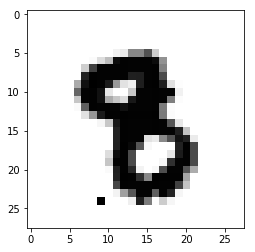

In [170]:
image_array = np.asfarray(temp_mnist).reshape((28,28))
plt.imshow(image_array, cmap='Greys', interpolation='None')

In [171]:
#How much a single pixel can change the confidence interval by.
print(fobj(test_data[1:],test_data[0]) - fobj(temp_mnist,test_data[0]))

0.12134124283360492


In [193]:
zero_diff = []
test_results = []

for n in range(len(test_data_list)):
    record = test_data_list[n]
    values = record.split(',')
    correct_label = int(values[0])
    inputs = (np.asfarray(values[1:]) / 255.0 * 0.99) + 0.01
    cnn_result = cnn.query(inputs)
    cnn_result = cnn_result[correct_label][0]
    zero_pixel = diff_evo(values[1:], values[0])
    zero_pixel_result = zero_pixel[1]
    diff = (cnn_result - zero_pixel_result)
    zero_diff.append((correct_label, diff))
    test_results.append((n,diff,cnn_result,zero_pixel[1:]))   
    

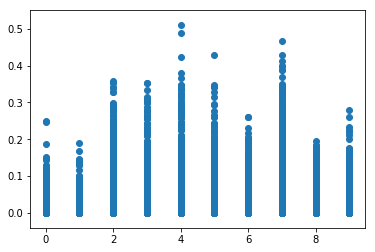

In [194]:
plt.scatter(*zip(*zero_diff))


In [195]:
curr_max = test_results[0][1]
max_index = 0
for i in range(1,len(test_results)):
    #curr_max = np.maximum(curr_max, test_results[i][1])
    if curr_max < test_results[i][1]:
        curr_max = test_results[i][1]
        max_index = i
print(curr_max)
print(max_index)

0.5097855026883584
2645


In [190]:
def print_image(index):
    test_data = test_data_list[index]
    test_data = test_data.split(',')
    temp_mnist = test_data[1:]
    temp_mnist[int(test_results[0][3][1])] = 254
    print("Confidence Interval weakened by: ",zero_diff[index][1])
    image_array = np.asfarray(temp_mnist).reshape((28,28))
    plt.imshow(image_array, cmap='Greys', interpolation='None')

Confidence Interval weakened by:  0.5097855026883584


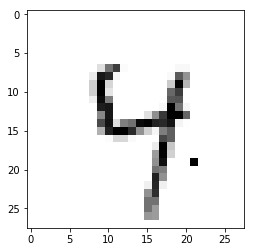

In [201]:
print("Confidence Interval weakened by: ",zero_diff[2645][1])
print_image(2645)

Confidence Interval weakened by:  0.0022226568347525344


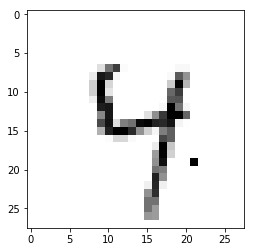

In [202]:
print("Confidence Interval weakened by: ",zero_diff[5000][1])
print_image(5000)

Confidence Interval weakened by:  0.0032253900028179627


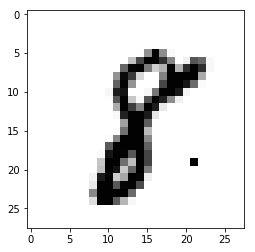

In [203]:
print("Confidence Interval weakened by: ",zero_diff[7500][1])
print_image(7500)

Confidence Interval weakened by:  0.0005051808201713692


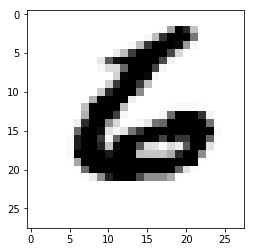

In [204]:
print("Confidence Interval weakened by: ",zero_diff[9999][1])
print_image(9999)

Confidence Interval weakened by:  0.0505044822602434


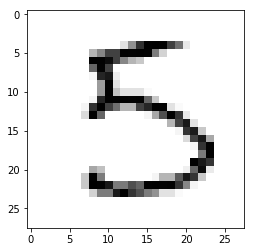

In [205]:
print("Confidence Interval weakened by: ",zero_diff[15][1])
print_image(15)

Confidence Interval weakened by:  0.1188464590075412


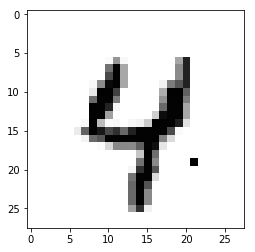

In [206]:
print("Confidence Interval weakened by: ",zero_diff[1111][1])
print_image(1111)

As this MNIST data set is pretty simple, the max value we were able to lower the confidence interval was about 0.510. From the scatter plot, we can see that certain numbers (0,1,8) are most robust against a zero-pixel attack. This method would be a good way of robustness testing a CNN for classifying images. It will help pinpoint certain classifiers that may need more training to be entirely effective (4,5,7).